In [1]:
import os
import pathlib
import numpy as np
import tensorflow as tf
import math
print(os.path.sep)

\


In [27]:
t = tf.random.normal([8, 256, 256, 3])
min = tf.reduce_mean(t)
min

<tf.Tensor: shape=(), dtype=float32, numpy=-0.00092447206>

In [28]:
model = tf.saved_model.load("C:\\Users\had-int22\PycharmProjects\AnomalyDetection\saved_models\data\mvtec\\resnetCAE\l2\\28-09-2022_09-12-11\\resnetCAE_b16_e20.hdf5")

In [2]:
from preprocessing import Preprocessor
preprocessor = Preprocessor("./data/mvtec", batch_size=8)
preprocessor.load_dataset()
train_ds, valid_ds = preprocessor.get_train_dataset(0.1, "gray")

Start creating dataset... 

The number of train data: 3266
The number of fine-tuning data: 536
The number of test data: 1552
(256, 256, 1) (256, 256, 1)
Start creating dataset... 

The number of train data: 3266
The number of fine-tuning data: 536
The number of test data: 1552


In [3]:
sample = train_ds.as_numpy_iterator()
next(iter(sample))[0].shape

(8, 256, 256, 1)

In [4]:
pred_x = model(next(iter(sample))[0])
pred_x.shape

NameError: name 'model' is not defined

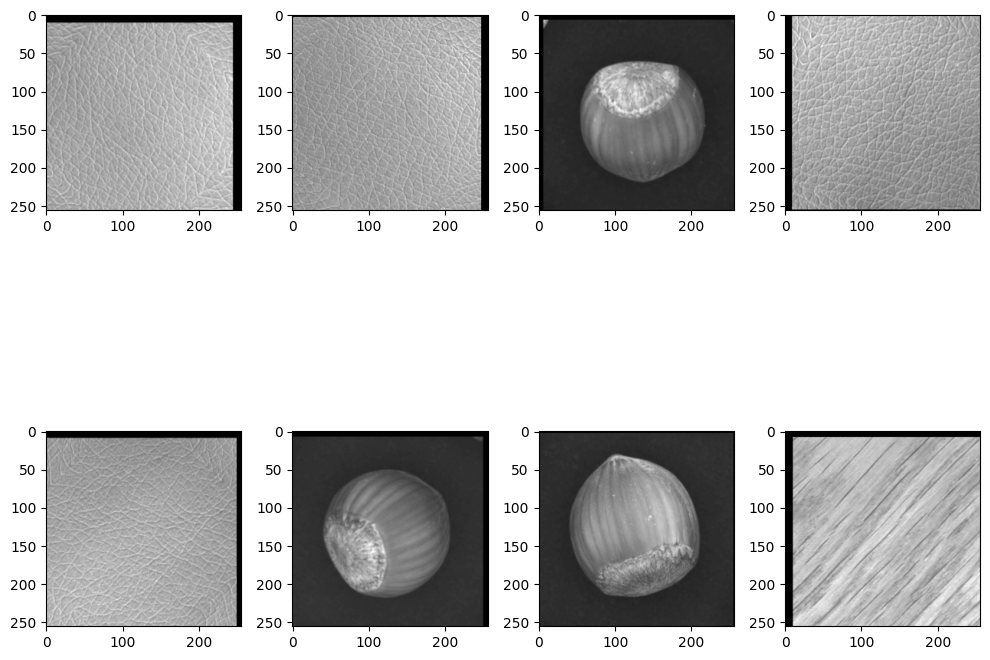

In [7]:
import matplotlib.pyplot as plt

sample = next(iter(sample))

fig = plt.figure(figsize=(10, 10))
for i in range(8):
    ax = plt.subplot(2, 4, i+1)
    plt.imshow(sample[i], cmap="gray")
plt.tight_layout()

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [5]:
# Get the list of file path of a train image in the data_dir.
data_dir = "../data/mvtec"
data_dir = pathlib.Path(data_dir)
list_train = list(data_dir.glob("*/train/good/*.png"))
list_test = list(data_dir.glob("*/test/*/*.png"))
num_train = len(list_train)  # the number of train images.
num_test = len(list_test)

# Create train/test dataset. Each element in the dataset is path of image file.
list_train_ds = tf.data.Dataset.list_files(str(data_dir/"*/train/good/*.png"), shuffle=False)
list_test_ds = tf.data.Dataset.list_files(str(data_dir/"*/test/*/*.png"), shuffle=False)

# Shuffle these dataset once.
list_train_ds = list_train_ds.shuffle(buffer_size=num_train, reshuffle_each_iteration=False)
list_test_ds = list_test_ds.shuffle(buffer_size=num_test, reshuffle_each_iteration=False)

list_train_ds_s = list_train_ds.skip(int(0.9 * num_train))
list_train_ds_l = list_train_ds.take(int(0.9 * num_train))
list_test_ds_s = list_test_ds.skip(int(0.9 * num_test))
list_test_ds_l = list_test_ds.take(int(0.9 * num_test))

print(f"list_train_s count: {list_train_ds_s.cardinality()} \n list_train_l count: {list_train_ds_l.cardinality()}")
print(f"list_test_s count: {list_test_ds_s.cardinality()} \n list_test_l count: {list_test_ds_l.cardinality()}")

print(f"train count: {num_train} , test count: {num_test}")

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: ..\\data\\mvtec\\*\\train\\good\\*.png'

In [11]:
a = [[1,2,3], [4,5,6]]

In [12]:
[item for sublist in a for item in sublist]

[1, 2, 3, 4, 5, 6]

In [65]:
train_ds = list_train_ds_l
finetune_ds = list_train_ds_s.concatenate(list_test_ds_s)
eval_ds = list_test_ds_l

print(f"fine_tune_ds: {finetune_ds.cardinality().numpy()}")

fine_tune_ds: 536


In [61]:
class_names = [item for item in data_dir.glob("*") if item.is_dir()]
class_names

[WindowsPath('../data/mvtec/bottle'),
 WindowsPath('../data/mvtec/cable'),
 WindowsPath('../data/mvtec/capsule'),
 WindowsPath('../data/mvtec/carpet'),
 WindowsPath('../data/mvtec/grid'),
 WindowsPath('../data/mvtec/hazelnut'),
 WindowsPath('../data/mvtec/leather'),
 WindowsPath('../data/mvtec/metal_nut'),
 WindowsPath('../data/mvtec/pill'),
 WindowsPath('../data/mvtec/screw'),
 WindowsPath('../data/mvtec/tile'),
 WindowsPath('../data/mvtec/toothbrush'),
 WindowsPath('../data/mvtec/transistor'),
 WindowsPath('../data/mvtec/wood'),
 WindowsPath('../data/mvtec/zipper')]

In [72]:
parts = tf.strings.split(next(train_ds.take(1)).numpy(), os.path.sep)

TypeError: 'TakeDataset' object is not an iterator

In [89]:
file_path = list(train_ds.as_numpy_iterator())[:5]
file_path

[b'..\\data\\mvtec\\screw\\test\\good\\035.png',
 b'..\\data\\mvtec\\tile\\test\\crack\\000.png',
 b'..\\data\\mvtec\\hazelnut\\test\\cut\\013.png',
 b'..\\data\\mvtec\\metal_nut\\test\\bent\\002.png',
 b'..\\data\\mvtec\\screw\\test\\thread_side\\016.png']

In [114]:
file_path = list(train_ds.as_numpy_iterator())[:5]
parts = tf.strings.split(file_path, os.path.sep)
sub_dir = parts[:, -2:-1].numpy()
print(sub_dir.squeeze())
# for part in parts:
#     print(part.numpy())
label = (sub_dir == b'good').astype(np.int32)
label.shape

[b'good' b'crack' b'cut' b'bent' b'thread_side']


(5, 1)

In [121]:
file_path = list(train_ds.as_numpy_iterator())[1]
file_path

b'..\\data\\mvtec\\tile\\test\\crack\\000.png'

In [122]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    label = int(parts[-2] == b'good')
    return label
get_label(file_path)

0